# Prediction de l'accélération et du freinage avec nuScenes

In [2]:
%matplotlib inline

from nuscenes.nuscenes import NuScenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data/sets/nuscenes
# D:\Utilisateurs\Alexandre\Repertoire_D\nuscenes\v1 0-trainval01

#nusc = NuScenes(version='v1.0-mini', dataroot='../data/sets/nuscenes')
nusc = NuScenes(version='v1.0-trainval', dataroot='G:/repertoire_g/datafull')
nusc_can = NuScenesCanBus(dataroot='G:/repertoire_g/datafull')

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 267.1 seconds.
Reverse indexing ...
Done reverse indexing in 400.5 seconds.


# Anticiper la vitesse avec un véhicule en face

Principe de base (idée): 
    - le système de pilotage envoie les postions gps à suivre, la vitesse et l'angle recommandés à l'algorithme de gestion
    - l'algorithme de gestion en fonction de la situation va envoyer sur un modèle pour donner une nouvelle valeur de la vitesse et de l'angle par rapport à l'environnement
    - plusieurs modèles, mais en premier un basique : s'il y a personne en face on change rien, sinon calcul de la nouvelle vitesse par rapport au véhicule devant.
Pour cela, il nous faut plusieurs données pour ce modèle:
    - position, vitesse, orientation du véhicule égo (nous) et du véhicule en face
    - à compléter?
        

# 1/ Recherche de ces données

Prenons une scene où on suit une voiture, la scène 61. Cherchons l'instance de la voiture....

In [3]:
scene_test = nusc.scene[58] # 58 avec le dataset normal #0 avec le minidataset
scene_test

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [4]:
sample = nusc.get('sample',scene_test['last_sample_token'])
ann = sample['anns'][1]
ann_meta = nusc.get('sample_annotation', ann)
#nusc.list_sample(sample['token'])
sample

{'token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'timestamp': 1532402946797517,
 'prev': '29e056fc277543c9bc42310b122c640e',
 'next': '',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': 'bcb7aae01326408a8596c615edaf7bd1',
  'RADAR_FRONT_LEFT': '6ff82f2b2ad34049bb8355d8f8746ded',
  'RADAR_FRONT_RIGHT': 'f947592fe204415eb6d6d3c6aeedb310',
  'RADAR_BACK_LEFT': '21d33cfce1034fa198b7291997802031',
  'RADAR_BACK_RIGHT': '4556c9fb83824b0bb5f7dd9549fa9247',
  'LIDAR_TOP': '202d8a4cc24045a08f6ece5876b42d5c',
  'CAM_FRONT': 'bf8c213cfaad4861907cd2677dc2dbcd',
  'CAM_FRONT_RIGHT': 'dec67aad16564f4bb4308ec3f618b0ff',
  'CAM_BACK_RIGHT': 'a4d57a738cf14a458af5850f8a62e3e5',
  'CAM_BACK': 'c7f74cd185194eddbe447ad3506588da',
  'CAM_BACK_LEFT': 'ce7f2a8f2cab45d589d94774bb7e94c2',
  'CAM_FRONT_LEFT': 'd8b08803b5d144559aec12572001d690'},
 'anns': ['8bb63134d48840aaa2993f490855ff0d',
  '004e27d301fd4c35bd8c7d8a4124fc97',
  'dadd01f36e57408b85b66b0c5bc62874',
  '03873626ed7e4cba8

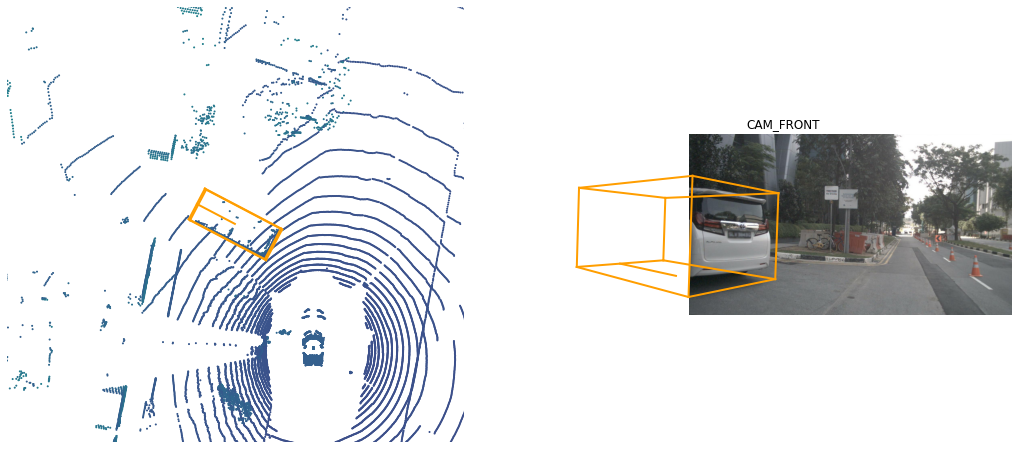

In [5]:
liste_vehicle = []
for at in sample['anns']:
    meta_data = nusc.get('sample_annotation',at)
    if meta_data['category_name'] == 'vehicle.car': 
        liste_vehicle += [meta_data]
nusc.render_annotation("bc3180b07f8e4a728f504ded654df56f")

Token de l'instance de la voiture que l'on suit: c1958768d48640948f6053d04cffd35b

Maintenant, comparons la position de cette voiture à la notre. `field2token` permet d'accéder à la liste de tout les enregistrements d'une scene.

In [6]:
meta_data

{'token': '1ae79db45dd44f238c0af4009a5b1af6',
 'sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'instance_token': 'e045fa4da9e64d759fb780b20c707b3e',
 'visibility_token': '4',
 'attribute_tokens': [],
 'translation': [453.386, 1088.271, 0.495],
 'size': [0.582, 0.578, 0.844],
 'rotation': [0.2152466821173414, 0.0, 0.0, 0.9765597093048004],
 'prev': '06615b130d4a4f949231a857952783ac',
 'next': '',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'movable_object.trafficcone'}

In [7]:
ann_tokens = set(nusc.field2token('sample_annotation','instance_token',"c1958768d48640948f6053d04cffd35b"))
def print_pos_rot(pos,rot):
    print("{:04.2f} {:04.2f} {:04.2f}".format(pos[0],pos[1],pos[2]))
    print("{:04.2f} {:04.2f} {:04.2f}".format(rot[0],rot[1],rot[2]))

ego_pos = []
voiture_pos = []
ego_rot = []
voiture_rot = []
for at in ann_tokens:
    meta_data = nusc.get('sample_annotation',at)
    sample = nusc.get('sample',meta_data['sample_token'])
    timestamp = sample['timestamp']
    lidar = nusc.get('sample_data',sample['data']['LIDAR_TOP'])
    ego_token = lidar['ego_pose_token']
    ego = nusc.get('ego_pose',ego_token)
    #print_pos_rot(ego['translation'],ego['rotation'])
    #nt_pos_rot(meta_data['translation'],meta_data['rotation'])
    #print(meta_data['rotation'])
    ego_pos += [ego['translation']]
    ego_rot += [ego['rotation']]
    voiture_pos += [meta_data['translation']]
    voiture_rot += [meta_data['rotation']]    

#print(nusc.ego_pose[:300])
print(nusc.ego_pose[0])
len(nusc.ego_pose)

{'token': 'bddd80ae33ec4e32b27fdb3c1160a30e', 'timestamp': 1531883530440378, 'rotation': [-0.7504501527141022, -0.0076295847961364415, 0.00847103369020136, -0.6608287216181199], 'translation': [1010.1273947164545, 610.7727090350685, 0.0]}


2631083

Maintenant qu'on a les données de position de notre véhicule et celui d'en face, on peut essayer de visualiser sur la map ce qu'il en est pour pouvoir déterminer une formule/ fonction pour savoir si une voiture est en face de nous (sur la même voie serait l'idéal.
Problème, la rotation est en écriture quaternion (je ne sais pas comment manipuler), donc en attendant je vais essayer de détecter le véhicule en face par rapport à s'il est détecté par la caméra frontale puis en calculant la distance.


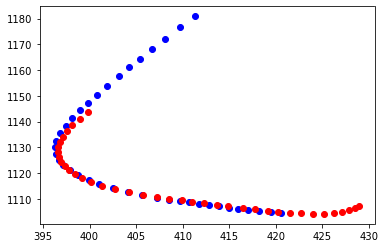

In [8]:
df_ego_pos = pd.DataFrame(ego_pos,columns=["x","y","z"])
#print(ego_rot)
#df_ego_rot = pd.DataFrame(ego_rot,columns=["x","y","z"])
df_voiture_pos = pd.DataFrame(voiture_pos,columns=["x","y","z"])
#df_voiture_rot = pd.DataFrame(voiture_rot,columns=["x","y","z"])
plt.plot(df_ego_pos["x"],df_ego_pos["y"],'bo')
plt.plot(df_voiture_pos["x"],df_voiture_pos["y"],'ro')


# 2/ Pretraitement sur les données
En regardant le code du sdk j'ai trouvé un bout de code utile qui me permet de savoir quel caméra a détecté l'annotation. Pour faire simple, je vais considérer (actuellement, cela va peut-être changer), qu'une voiture est en face de la notre si elle est détectée seulement par la caméra frontale et qu'elle respecte une certaine distance. Je vais maintenant regrouper toute ces données où on a une voiture en face nous.

`get_sample_data` renvoie plusieurs informations dont une liste de boxe de la caméra, si on lui passe un token en paramètre, il renvoie une seul boxe si l'instance est capturé par la caméra, rien sinon.

On peut maintenant créer le dataframe contenant toutes les informations: vitesse,distance,timestamp,accélération, token....
Voir `vehicle_data.csv`

In [9]:
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility

# renvoie vrai et un un tableau rempli si l'instance est en face d'ego et ego ne tourne pas trop
def find_vehicle_in_front(instance_token):
    instance = nusc.get('instance',instance_token)
    last_token = instance["last_annotation_token"]
    curr_token = instance["first_annotation_token"]
    rows_list = []
    i = 0
    
    ann = nusc.get('sample_annotation',instance["first_annotation_token"])
    sample = nusc.get('sample',ann['sample_token'])
    scene = nusc.get('scene',sample['scene_token'])
    dict_scene = nusc_can.get_messages(scene['name'],'vehicle_monitor') 
    taille = len(dict_scene)
    # Traitement sur tout les vehicules ou non (a faire)
    all_camera = False
    if all_camera:
        list_cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
    else:
        list_cams = ['CAM_FRONT']
        
    # Pour chaque enregistrement de l'annoation on ajoute une ligne avec les elements
    while curr_token != last_token:
        curr_ann = nusc.get('sample_annotation',curr_token)
        curr_sample = nusc.get('sample',curr_ann['sample_token'])        
        cams_check = []
        # (abs(dict_scene[i]['utime'] - curr_sample['timestamp']) > 250000 ) and
        while i < taille - 2 and   (dict_scene[i]['utime'] < curr_sample['timestamp']):
            #print("avance: ",i,curr_sample['timestamp']-1532402900000000," ",dict_scene[i]['utime']-1532402900000000)
            i += 1
        #print(curr_sample['timestamp'] - 1532402900000000,dict_scene[i]['utime'] - 1532402900000000  )  
        # récupérer les caméras qui ont vu l'annotation

        _, boxes, _ = nusc.get_sample_data(curr_sample['data']['CAM_FRONT'], box_vis_level=BoxVisibility.ANY,
                                                selected_anntokens=[curr_token])
        #and abs(dict_scene[i]['steering']) < 100
        if len(boxes) > 0:
            #calcul distance entre ego et le vehicule
            lidar = nusc.get('sample_data',curr_sample['data']['LIDAR_TOP'])
            ego = nusc.get('ego_pose',lidar['ego_pose_token'])
            dist = np.linalg.norm(np.array(ego['translation']) - np.array(curr_ann['translation']))
            ego_pos = [round(e,3) for e in ego['translation']]
            object_pos = [round(e,3) for e in curr_ann['translation']]

            dic = {'scene':scene['name'],'timestamp':curr_sample['timestamp'],'utime':dict_scene[i]['utime'],'inst_token':instance_token,
                   'ann_token':curr_token,'ego_pos':ego_pos,'object_pos':object_pos,
                   'distance':round(dist,3),'steering':round(dict_scene[i]['steering'],3),'ego_speed':round(dict_scene[i]['vehicle_speed'],3),
                   'throttle':dict_scene[i]['throttle'],'brake':dict_scene[i]['brake'],'future_throttle':dict_scene[i+1]['throttle'],
                   'future_brake':dict_scene[i+1]['brake'],'futur_speed':round(dict_scene[i+1]['vehicle_speed'],3)}
            rows_list += [dic]
                
        curr_token = curr_ann['next']   
        if i < taille - 2:
            i += 1
    #print(len(rows_list),len(dict_scene))
    return len(rows_list)!=0,rows_list

# renvoie un tableau rempli pour toute la scene avec les données du véhicule
def vehicle_info(scene):
    #sample = nusc.get('sample',scene['first_sample_token'])
    curr_token = scene['first_sample_token']
    rows_list = []
    last_token = scene['last_sample_token']
    i = 0

    dict_scene = nusc_can.get_messages(scene['name'],'vehicle_monitor') 
    taille = len(dict_scene)
    
    # Pour chaque enregistrement de la scene on ajoute une ligne avec les elements
    while curr_token != last_token:
        curr_sample = nusc.get('sample',curr_token)        
        while i < taille -2 and  (dict_scene[i]['utime']  < curr_sample['timestamp']):
            i += 1
        #print(curr_sample['timestamp'] - 1532402900000000,dict_scene[i]['utime'] - 1532402900000000  )  ['']
        lidar = nusc.get('sample_data',curr_sample['data']['LIDAR_TOP'])
        ego = nusc.get('ego_pose',lidar['ego_pose_token'])
        ego_pos = [round(e,3) for e in ego['translation']]
        dic = {'scene':scene['name'],'timestamp':curr_sample['timestamp'],'utime':dict_scene[i]['utime'],'inst_token':"vehicle_info",
               'ann_token':curr_token,'ego_pos':ego_pos,'object_pos':ego_pos,
               'distance':99,'steering':round(dict_scene[i]['steering'],3),'ego_speed':round(dict_scene[i]['vehicle_speed'],3),'throttle':dict_scene[i]['throttle'],
               'brake':dict_scene[i]['brake'],'future_throttle':dict_scene[i+1]['throttle'],'future_brake':dict_scene[i+1]['brake'],
               'futur_speed':round(dict_scene[i+1]['vehicle_speed'],3)}
        rows_list += [dic]
        curr_token = curr_sample['next']   
        if i < taille - 2:
            i += 1
    #print(len(rows_list),len(dict_scene))
    return rows_list
_ ,dic = find_vehicle_in_front("c1958768d48640948f6053d04cffd35b")
#print(dic)
df = pd.DataFrame.from_dict(dic).sort_values(by='timestamp').reset_index(drop=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
0,scene-0061,1532402927647951,1532402928127800,c1958768d48640948f6053d04cffd35b,49f76277d07541c5a584aa14c9d28754,"[411.304, 1180.89, 0.0]","[399.863, 1143.574, 0.738]",39.038,3.0,31.44,0,0,0,0,30.73
1,scene-0061,1532402928147847,1532402928627159,c1958768d48640948f6053d04cffd35b,ae589a5a2bdb4813ae8021cd51b7e6eb,"[409.743, 1176.677, 0.0]","[398.996, 1141.132, 0.738]",37.142,3.5,30.73,0,0,0,0,29.45
2,scene-0061,1532402928698048,1532402929127810,c1958768d48640948f6053d04cffd35b,e7a2133afb9c4c9b834225cc959d475a,"[408.102, 1172.152, 0.0]","[398.116, 1138.632, 0.738]",34.983,3.6,29.45,0,0,0,0,28.09
3,scene-0061,1532402929197353,1532402929627057,c1958768d48640948f6053d04cffd35b,5a390e5c3f6249bb9f99c9be52614dd2,"[406.726, 1168.211, 0.0]","[397.624, 1136.322, 0.738]",33.171,3.6,28.09,0,0,0,0,27.07
4,scene-0061,1532402929697797,1532402930127656,c1958768d48640948f6053d04cffd35b,0e5ab4ede0ad4cafaee8de500415e29a,"[405.409, 1164.354, 0.0]","[397.133, 1134.052, 0.738]",31.421,3.5,27.07,0,0,0,0,26.25
5,scene-0061,1532402930152601,1532402930627445,c1958768d48640948f6053d04cffd35b,4a8dd530b1144dd1b8217dbe74b60e63,"[404.278, 1161.05, 0.0]","[396.794, 1132.149, 0.738]",29.863,3.6,26.25,0,0,0,0,25.35
6,scene-0061,1532402930648325,1532402931127168,c1958768d48640948f6053d04cffd35b,92a23fb25b98444e93afd004ca31cca2,"[403.115, 1157.518, 0.0]","[396.625, 1130.226, 0.763]",28.063,4.0,25.35,0,0,0,0,24.51
7,scene-0061,1532402931198511,1532402931627135,c1958768d48640948f6053d04cffd35b,5e5e0db2bcf642d680865d7c88a62f76,"[401.882, 1153.723, 0.0]","[396.575, 1128.037, 0.788]",26.240,4.7,24.51,0,0,0,0,23.58
8,scene-0061,1532402931697833,1532402932127384,c1958768d48640948f6053d04cffd35b,49e7210442be48f495c50e38a50abdbf,"[400.841, 1150.404, 0.0]","[396.706, 1126.176, 0.822]",24.592,6.5,23.58,0,0,0,0,22.69
9,scene-0061,1532402932197715,1532402932626799,c1958768d48640948f6053d04cffd35b,bb4c6ddbf99a4f1c930d01efd0bbfcd3,"[399.844, 1147.174, 0.0]","[396.978, 1124.331, 0.855]",23.037,12.6,22.69,0,0,0,0,21.89


In [10]:
blackint = nusc_can.can_blacklist
blacklist = [ "scene-0"+ str(i) for i in blackint]
# 1532402936198962 1532402936699359 1532402937198682

# Liste toutes les instances d'une scene
def get_instances_scene(scene):
    sample = nusc.get('sample',scene['first_sample_token'])
    list_instances = []
    while sample['token'] != scene['last_sample_token']:
        anns = sample['anns']
        for ann_token in anns:
            ann = nusc.get('sample_annotation',ann_token)
            instance = nusc.get('instance',ann['instance_token'])
            category = nusc.get('category',instance['category_token'])
            if not instance in list_instances and "vehicle" in category['name']:
                list_instances += [instance]
        sample = nusc.get('sample',sample['next'])
    return list_instances

# Renvoie un dataframe contenant les données de toutes les instances de la scene
def build_dataframe_for_one_scene(s,affichage):
    list_rows = vehicle_info(s)
    list_instances = get_instances_scene(s)
    for inst in list_instances:
        ok, res = find_vehicle_in_front(inst['token'])
        if affichage:
            print(len(res)," echantillons")   
        if ok:
            list_rows += res
    return pd.DataFrame.from_dict(list_rows).sort_values(by='timestamp').reset_index(drop=True)

# Explore chaque scene, puis chaque instance de cette scene qui est un vehicle en mouvement (devant)
# Cree un dataframe avec pour entree distance au vehicle, ego_vitesse, ego_accel, ego_brake 
# et vehicle_vitesse (pas mtn)
def build_dataframe_for_vehicle_in_front():
    scenes = nusc.scene
    list_rows = []
    first = True
    i = 0
    for s in scenes[:10]:
        if s['name'] not in blacklist and s['name']  not in ["scene-0003","scene-0419"]:
            #print(s['name'])
            if i % 100 == 0:
                print("#",end='')
            if first:
                dataframe = build_dataframe_for_one_scene(s,False)
                first = False
            else:
                datatemp = build_dataframe_for_one_scene(s,False)
                dataframe = dataframe.append(datatemp,ignore_index=True)
            i += 1

    print(dataframe)
    print(dataframe.describe())
    return dataframe
    
#find_vehicle_in_front("c1958768d48640948f6053d04cffd35b")
# 15k ligne sans contrainte sur steering (100 scenes)
df_vehicle = build_dataframe_for_vehicle_in_front()
df_vehicle = df_vehicle.sort_values(by=['timestamp'])
#df_vehicle.to_csv(path_or_buf="./data/vehicle_data0807.csv",index=False)
#df_brake = df_vehicle[['scene','brake']]
#df_brake.to_csv('./data/vehicle_brake_25j.csv')
scene_name = 'scene-0006'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
scene = nusc.get('scene',my_scene_token)
#nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
df = build_dataframe_for_one_scene(scene,False)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
display(df)
df.to_csv("./data/0707test_df_one_scene2.csv")

#           scene         timestamp             utime  \
0     scene-0001  1531883530449377  1531883530891054   
1     scene-0001  1531883530449377  1531883530891054   
2     scene-0001  1531883530949817  1531883531391621   
3     scene-0001  1531883530949817  1531883531391621   
4     scene-0001  1531883530949817  1531883531391621   
...          ...               ...               ...   
1176  scene-0010  1531884408947316  1531884409387847   
1177  scene-0010  1531884408947316  1531884409387847   
1178  scene-0010  1531884408947316  1531884409387847   
1179  scene-0010  1531884409447745  1531884409887908   
1180  scene-0010  1531884409948703  1531884410387739   

                            inst_token                         ann_token  \
0                         vehicle_info  e93e98b63d3b40209056d129dc53ceee   
1     39b6c31c9925492a8a9f1b0ef3b877b6  acce0b7220754600b700257a1de1573d   
2     a1f53dd65da64eb2b0cec51d57b8c047  405f156885d549ca812e1305eddee42f   
3                     

,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
0,scene-0006,1531884156948944,1531884157388713,vehicle_info,7ba9d78d92914fd5a204d3bc1233bd4e,"[683.173, 1470.356, 0.0]","[683.173, 1470.356, 0.0]",99.000,-3.6,34.70,0,0,0,0,33.16
1,scene-0006,1531884156948944,1531884157388713,37efe5932d7f4084ac8ed3bbb5ed6220,cf16c1629e1a4567b12299ff690b4fa0,"[683.173, 1470.356, 0.0]","[690.236, 1472.951, 0.313]",7.531,-3.6,34.70,0,0,0,0,33.16
2,scene-0006,1531884156948944,1531884157388713,23e14d768eab400099c816a3ac0ff041,f2e8009aebbc4b57b7392ed22b253c62,"[683.173, 1470.356, 0.0]","[733.16, 1478.509, 0.882]",50.655,-3.6,34.70,0,0,0,0,33.16
3,scene-0006,1531884156948944,1531884157388713,98300b9c4acb4da9a7aecd0084650265,81a58ca596b84dee9eef8bd4bfa5c4a0,"[683.173, 1470.356, 0.0]","[753.811, 1459.166, -2.519]",71.563,-3.6,34.70,0,0,0,0,33.16
4,scene-0006,1531884156948944,1531884157388713,56a9802dbe824219992d60debdea6646,1da660badfb046a19c47088ac5587d00,"[683.173, 1470.356, 0.0]","[701.905, 1458.872, -0.088]",21.972,-3.6,34.70,0,0,0,0,33.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,scene-0006,1531884175949222,1531884176388257,8c4d4351c48240aab819b21e3c68c61a,002f823fa0384418af30e9dc1b045f46,"[776.432, 1464.865, 0.0]","[784.076, 1502.842, 1.201]",38.758,126.8,11.22,37,0,66,0,11.03
118,scene-0006,1531884175949222,1531884176388257,838b5ef900a140aa9b2ac9c256cc2f2e,c9be8430a91640bb81c0f76d063fa9e7,"[776.432, 1464.865, 0.0]","[775.574, 1485.729, 1.176]",20.915,126.8,11.22,37,0,66,0,11.03
119,scene-0006,1531884175949222,1531884176388257,vehicle_info,825a78d231eb472a8538e20f86bae562,"[776.432, 1464.865, 0.0]","[776.432, 1464.865, 0.0]",99.000,126.8,11.22,37,0,66,0,11.03
120,scene-0006,1531884175949222,1531884176388257,d84618c0be744031aeabc03a21f32163,9d761c3ec5a9415aab53db2db10bdd5b,"[776.432, 1464.865, 0.0]","[774.862, 1508.858, 2.277]",44.080,126.8,11.22,37,0,66,0,11.03


In [11]:
scene_name = 'scene-0061'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
scene = nusc.get('scene',my_scene_token)
#nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
df = build_dataframe_for_one_scene(scene,False)
display(df)

,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
0,scene-0061,1532402927647951,1532402928127800,vehicle_info,ca9a282c9e77460f8360f564131a8af5,"[411.304, 1180.89, 0.0]","[411.304, 1180.89, 0.0]",99.000,3.0,31.44,0,0,0,0,30.73
1,scene-0061,1532402927647951,1532402928127800,a60047adc78a4b6895702e86b6d2fe88,b7cbc6d0e80e4dfda7164871ece6cb71,"[411.304, 1180.89, 0.0]","[388.978, 1139.303, 0.98]",47.211,3.0,31.44,0,0,0,0,30.73
2,scene-0061,1532402927647951,1532402928127800,e3c5b72c12c34c85aac247734ad83bef,91cb8f15ed4444e99470d43515e50c1d,"[411.304, 1180.89, 0.0]","[398.565, 1110.043, 1.788]",72.006,3.0,31.44,0,0,0,0,30.73
3,scene-0061,1532402927647951,1532402928127800,42641eb6adcb4f8f8def8ef129d9e843,a6f7d4bb60374f868144c5ba4431bf4c,"[411.304, 1180.89, 0.0]","[360.932, 1129.086, 0.585]",72.259,3.0,31.44,0,0,0,0,30.73
4,scene-0061,1532402927647951,1532402928127800,85246a44cc6340509e3882e2ff088391,cda0a9085607438c9b1ea87f4360dd64,"[411.304, 1180.89, 0.0]","[394.039, 1143.246, 0.615]",41.419,3.0,31.44,0,0,0,0,30.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,scene-0061,1532402945697148,1532402946627093,c1958768d48640948f6053d04cffd35b,cad8d5a3f7cc4c55bc44da68369f49da,"[418.165, 1105.272, 0.0]","[427.868, 1105.779, 1.105]",9.779,155.8,7.50,0,6,0,2,6.12
311,scene-0061,1532402946297085,1532402946627093,vehicle_info,29e056fc277543c9bc42310b122c640e,"[419.527, 1104.831, 0.0]","[419.527, 1104.831, 0.0]",99.000,155.8,7.50,0,6,0,2,6.12
312,scene-0061,1532402946297085,1532402946627093,f0056532879643c69e4efc9d845782f0,93bbd23c226d4fbf8c2b6c58a24c61c5,"[419.527, 1104.831, 0.0]","[435.372, 1103.171, 0.864]",15.955,155.8,7.50,0,6,0,2,6.12
313,scene-0061,1532402946297085,1532402946627093,c1958768d48640948f6053d04cffd35b,d02856dbe859476f9635f449d23aa211,"[419.527, 1104.831, 0.0]","[428.504, 1106.56, 1.188]",9.219,155.8,7.50,0,6,0,2,6.12


Scène intéressante pour prédire le frein: 14 
Scène avec piéton: 25,29,43

Il pourrait être intéressant de pouvoir afficher la scène avec les résultats de la prédiction

## Restreindre le dataframe à un véhicule par enregistrement

L'un des problèmes est que dans notre dataframe actuel on a tout les véhicules détectés par la caméra frontale, or, il faudrait limitier le nombre de véhicule à un pour chaque enregistrement, l'idéal étant de prendre celui qui est le plus prés d'ego et sur la même voie. Ci-dessous deux fonctions qui font le calcul, la première à partir du traitement de l'affichage de l'image avec cv2, le deuxième avec le cacul de victeur vitesse dans le monde

### Par l'image: CV2

In [12]:
import cv2
from typing import Tuple, List
import os.path as osp
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
import operator

# parametres pour cv2
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (0,500)
fontScale              = 1
fontColor              = (255,255,255)
color              = (255,0,0)
lineType               = 2
pas = (0,50)

def get_color(category_name: str) -> Tuple[int, int, int]:
    """
    Provides the default colors based on the category names.
    This method works for the general nuScenes categories, as well as the nuScenes detection categories.
    """
    if 'bicycle' in category_name or 'motorcycle' in category_name:
        return 255, 61, 99  # Red
    elif 'vehicle' in category_name or category_name in ['bus', 'car', 'construction_vehicle', 'trailer', 'truck']:
        return 255, 158, 0  # Orange
    elif 'pedestrian' in category_name:
        return 0, 0, 230  # Blue
    elif 'cone' in category_name or 'barrier' in category_name:
        return 0, 0, 0  # Black
    else:
        return 255, 0, 255  # Magenta

def affichage(im,df_curr):
           
    cv2.putText(im, 'Vitesse:'+ str(df_curr.iat[0,9]), 
        bottomLeftCornerOfText, 
        font, 
        fontScale, 
        fontColor,
        lineType)
    cv2.putText(im, 'Angle volant:'+ str(df_curr.iat[0,8]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,50))), 
        font, 
        fontScale, 
        fontColor,
        lineType)
    cv2.putText(im, 'Acceleration:'+ str(df_curr.iat[0,10]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,100))), 
        font, 
        fontScale, 
        fontColor,
        lineType)

    cv2.putText(im, 'Frein:'+ str(df_curr.iat[0,11]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,150))), 
        font, 
        fontScale, 
        fontColor,
        lineType)
    cv2.putText(im, 'Acceleration (Pred):'+ str(df_curr.iat[0,12]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,200))), 
        font, 
        fontScale, 
        fontColor,
        lineType)

    cv2.putText(im, 'Frein (Pred):'+ str(df_curr.iat[0,11]), 
        tuple(map(operator.add, bottomLeftCornerOfText,(0,250))), 
        font, 
        fontScale, 
        fontColor,
        lineType)

    if df_curr.shape[0] > 1:
        cv2.putText(im, 'Distance:'+ str(df_curr.iloc[1]['distance']), 
            tuple(map(operator.add, bottomLeftCornerOfText,(0,300))), 
            font, 
            fontScale, 
            color,
            lineType)    
        
def draw_rect(im,selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        cv2.line(im,
                 (int(prev[0]), int(prev[1])),
                 (int(corner[0]), int(corner[1])),
                 color, 2)
        prev = corner
        
def render_scene_channel_with_predict(nusc,
                        scene_token: str, dataframe,
                        channel: str = 'CAM_FRONT',
                        freq: float = 10,
                        imsize: Tuple[float, float] = (960, 540),
                        out_path: str = None) -> None:
    """
    Renders a full scene for a particular camera channel.
    :param scene_token: Unique identifier of scene to render.
    :param channel: Channel to render.
    :param freq: Display frequency (Hz).
    :param imsize: Size of image to render. The larger the slower this will run.
    :param out_path: Optional path to write a video file of the rendered frames.
    Reprise de la fonction render_scene_channel du sdk nuscenes mais avec beaucoup de changements
    Renvoie un dataframe avec un objet par timestamp 
    """
    valid_channels = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
                        'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']

    assert imsize[0] / imsize[1] == 16 / 9, "Aspect ratio should be 16/9."
    assert channel in valid_channels, 'Input channel {} not valid.'.format(channel)

    if out_path is not None:
        assert osp.splitext(out_path)[-1] == '.avi'

    # Get records from DB
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data'][channel])

    # Open CV init
    name = '{}: {} (Space to pause, ESC to exit)'.format(scene_rec['name'], channel)
    cv2.namedWindow(name)
    cv2.moveWindow(name, 0, 0)

    if out_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(out_path, fourcc, freq, imsize)
    else:
        out = None

    # parametres pour cv2
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,500)
    fontScale              = 1
    fontColor              = (255,255,255)
    color              = (255,0,0)
    lineType               = 2
    pas = (0,50)
    # parametres pour afficher infos
    i = 0
    taille = dataframe.shape[0]
    scene_token = nusc.field2token('scene', 'name', dataframe.at[0,'scene'])[0]
    scene = nusc.get('scene',scene_token)
    sample = nusc.get('sample',scene['first_sample_token'])
    df_curr = dataframe[dataframe['timestamp'] == sample['timestamp']]
    df_curr = df_curr.sort_values(by='distance').reset_index(drop=True)
    #print(df_curr)
    has_more_frames = True
    angle = df_curr.iat[0,8]
    xmin = 10
    xmax = - 10
    colors: Tuple = ((0, 0, 255), (255, 0, 0), (155, 155, 155))
    borne_a = 600
    borne_b = 1000
    new_df = pd.DataFrame(columns=df_curr.columns)
    while has_more_frames:
        ann = df_curr[df_curr["inst_token"]=="98300b9c4acb4da9a7aecd0084650265"]
        ann_tok = ann['ann_token']
        #print(df_curr['inst_token'])
        # selected_anntokens=[ann_tok.iat[0]]
        # Get data from DB
        impath, boxes, camera_intrinsic = nusc.get_sample_data(sd_rec['token'],
                                                                    box_vis_level=BoxVisibility.ANY)
        # Load and render
        if not osp.exists(impath):
            raise Exception('Error: Missing image %s' % impath)
        im = cv2.imread(impath)
        dmin = 999
        minbox = None
        df_wv = df_curr[df_curr["inst_token"]!="vehicle_info"]
        liste = []
        annmin = "none"
        for j in range(df_wv.shape[0]):
            ann = df_wv.iloc[j]['ann_token']
            impath, boxes, camera_intrinsic = nusc.get_sample_data(sd_rec['token'],
                                                            box_vis_level=BoxVisibility.ANY,
                                                            selected_anntokens=[ann])
            if len(boxes) != 0:
                liste += [(ann,boxes[0])]

        # Pour chaque couple annotation/box on cherche le plus prés d'ego en face
        for (a,box) in liste:
            corners = view_points(box.corners(), camera_intrinsic, normalize=True)[:2, :]
            if (box.center[2] < dmin and corners.T[4][0] < borne_b-angle and corners.T[6][0] > borne_a-angle 
                and "vehicle" in box.name):
                dmin = box.center[2]
                annmin = a
                minbox = box
                
        if dmin != 999:
            c = get_color(minbox.name)
            corners = view_points(minbox.corners(), camera_intrinsic, normalize=True)[:2, :]
            draw_rect(im,corners.T[4:], colors[1][::-1])
            
        if i%6 == 0 and i != 0:
            if dmin != 999:
                new_df = new_df.append(df_curr[df_curr['ann_token']==annmin])
            else:
                new_df = new_df.append(df_curr[df_curr['inst_token']=="vehicle_info"])


        # Affichage informations
        if sample['token'] != scene['last_sample_token']:
            if not df_curr.empty:
                if dmin != 999:
                    cv2.line(im, (int((corners.T[4][0]+corners.T[6][0])/2), 400), (int((corners.T[4][0]+corners.T[6][0])/2), 600), (255, 255, 0), thickness=2)
                    cv2.putText(im, 'Center:'+ str(round(minbox.center[0],3))+"\n      "+str(round(minbox.center[2],2)), 
                                (int(800+minbox.center[0]*10),250), 
                                font, 
                                fontScale, 
                                (255, 0, 255),
                                lineType)
                cv2.line(im, (int(borne_b-angle), 400), (int(borne_b-angle), 600), (255, 0, 0), thickness=2)
                cv2.line(im, (int(borne_a-angle), 400), (int(borne_a-angle), 600), (255, 0, 0), thickness=2)
                affichage(im,df_curr)
            else:
                print(sample['timestamp'])
            if i%6 == 0 and i != 0:
                sample = nusc.get('sample',sample['next'])
                df_curr = dataframe[dataframe['timestamp'] == sample['timestamp']]
                df_curr = df_curr.sort_values(by='distance').reset_index(drop=True)
                if not df_curr.empty:
                    angle = df_curr.iat[0,8]
                #angle = 0
        else:
            print("fin des données ",i)

            
        # Render
        im = cv2.resize(im, imsize)
        cv2.imshow(name, im)
        if out_path is not None:
            out.write(im)

        key = cv2.waitKey(1)  # Images stored at approx 10 Hz, so wait 10 ms.
        if key == 32:  # If space is pressed, pause.
            key = cv2.waitKey()

        if key == 27:  # if ESC is pressed, exit
            cv2.destroyAllWindows()
            break

        if not sd_rec['next'] == "":
            sd_rec = nusc.get('sample_data', sd_rec['next'])
        else:
            has_more_frames = False
        i += 1
    print("nombre de frame: ",i)
    new_df = new_df.reset_index(drop=True)

    #print(new_df)
    cv2.destroyAllWindows()
    if out_path is not None:
        out.release()
    return new_df


67,185,130,155 piéton traverse,
6 camion au milieu (pas mal), 41 on s'arrete devant une voiture a un feu (genial), 190
9,10 il se passe rien
14 arret puis démarrage car bus avance
45 à exclure 

In [13]:
scene_name = 'scene-0006'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
scene = nusc.get('scene',my_scene_token)
df = build_dataframe_for_one_scene(scene,False)
_ = render_scene_channel_with_predict(nusc,my_scene_token,df,'CAM_FRONT')

nombre de frame:  218


Calcul d'un premier jeu d'apprentissage à partir de scènes qui me semblent intéressantes

In [71]:
scene_name = 'scene-0160'
my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
scene = nusc.get('scene',my_scene_token)
#nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
#df = build_dataframe_for_one_scene(scene,False)
#print(df)
#df.to_csv(scene_name+".csv")
liste_scene = ['scene-0061','scene-0010','scene-0041','scene-0009','scene-0100',
'scene-0101','scene-0190','scene-0194']

liste_scene = ['scene-0061','scene-0010','scene-0041','scene-0009','scene-0100',
'scene-0101']
#liste_scene = ['scene-0108']
# render_scene_channel_with_predict(nusc,my_scene_token,df, 'CAM_FRONT')
df_for_predict = pd.DataFrame(columns=df.columns)
for s in liste_scene:
    s_token = nusc.field2token('scene', 'name', s)[0]
    scene = nusc.get('scene',s_token)
    df = build_dataframe_for_one_scene(scene,False)
    temp = render_scene_channel_with_predict(nusc,s_token,df, 'CAM_FRONT',imsize=(256,144))
    df_for_predict = df_for_predict.append(temp)
    
df_for_predict.to_csv("./data/df_predict_throttle_brake0707.csv")

nombre de frame:  224
nombre de frame:  228
nombre de frame:  231
nombre de frame:  227
nombre de frame:  229
nombre de frame:  230


### Par calcul de vecteur dans le monde

Nouvelle méthode pour traiter les données (similaire à render_scene_channel_with_predict) mais beaucoup plus rapide (car l'autre nécéssite de rendre en temps réel avec cv2 chaque scène), à partir du vecteur vitesse et de la distance à ego (même principe que pour l'animation de la scène)

In [70]:
blackint = nusc_can.can_blacklist
blacklist = [ "scene-0"+ str(i) for i in blackint]

def compute_near_vehicle_dataframe_one_scene(df):
    liste_temps = sorted(set(df['timestamp'].to_list()))
    new_df = pd.DataFrame(columns=df.columns)

    def compute_one_sample(frame):
        tstp = liste_temps[frame]
        #ego_pos = df[(df['timestamp']==tstp)&(df['inst_token']=='vehicle_info')]['ego_pos'].iloc[0]
        df_curr = df[(df['timestamp']==tstp)&(df['inst_token']!='vehicle_info')]
        list_pos = df_curr['object_pos'].to_list()
        if len(list_pos)!=0 :
            a = np.transpose(np.asarray(list_pos))
        if frame < len(liste_temps) - 2:
            tstp2 = liste_temps[frame+1]
            A = df[(df['timestamp']==tstp)&(df['inst_token']=='vehicle_info')]['ego_pos'].iloc[0]
            B = df[(df['timestamp']==tstp2)&(df['inst_token']=='vehicle_info')]['ego_pos'].iloc[0]
            AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
            if AB[0]*AB[0] + AB[1]*AB[1] != 0:
                ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)
            else:
                ABn = (0,0)
            if len(list_pos)!=0 :
                if ABn[0] == 0:
                    a = 0
                else:
                    a = ABn[1]/ABn[0]
                c = - A[0] * a + A[1]
                dmin = 50
                posmin = []
                row = None
                for j in range(df_curr.shape[0]):
                    p = df_curr.iloc[j]['object_pos']
                    d = np.absolute(p[1] - a * p[0] - c)/ np.sqrt(a*a + 1)
                    distance_ego = round(np.linalg.norm(np.array(A) - np.array(p)),3)
                    if distance_ego < dmin and d < 5:
                        dmin = distance_ego
                        posmin = p
                        row = df_curr.iloc[j]
                if posmin != []:
                    return row
                
    for i in range(len(liste_temps)):
        row = compute_one_sample(i)
        new_df = new_df.append(row)
    return new_df

def compute_near_vehicle_dataframe_all_scene():
    scenes = nusc.scene
    list_rows = []
    first = True
    i = 0
    scenes = scenes
    taille = len(scenes)
    for s in scenes:
        if i % (taille/10) == 0:
            print("#",end='')
        if s['name'] not in blacklist and s['name']  not in ["scene-0003","scene-0419"]:
            #scene_token = nusc.field2token('scene', 'name', s['name'])[0]
            #scene = nusc.get('scene',scene_token)
            #nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
            df = build_dataframe_for_one_scene(s,False)
            if first:
                new_df = compute_near_vehicle_dataframe_one_scene(df)
                first = False
            else:
                return_df = compute_near_vehicle_dataframe_one_scene(df)
                new_df = new_df.append(return_df)
            i+=1
    return new_df
             
#near_df = compute_near_vehicle_dataframe_all_scene()
print(near_df.shape)
near_df.to_csv("./data/near_dataframe_full0707.csv")

##########(15794, 15)


In [61]:
display(near_df)

,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,brake_activate
6,scene-0001,1531883531450214,1531883531890914,39b6c31c9925492a8a9f1b0ef3b877b6,8feca495e3614382b12a6637c82c4670,"[1010.029, 614.858, 0.0]","[1002.499, 632.296, 1.736]",19.073,206.3,15.19,158,0,182,0,1
11,scene-0001,1531883531950107,1531883532391342,39b6c31c9925492a8a9f1b0ef3b877b6,e70a018c1c5541069187b4fdad085b43,"[1009.423, 616.759, 0.0]","[1002.407, 632.18, 1.636]",17.021,192.3,16.10,182,0,202,0,1
13,scene-0001,1531883532449967,1531883532891863,39b6c31c9925492a8a9f1b0ef3b877b6,818fbb98a43b4d7e8ff39e2048b2ff0b,"[1008.359, 618.663, 0.0]","[1002.336, 632.183, 1.586]",14.886,120.1,17.24,202,0,192,0,1
21,scene-0001,1531883533049931,1531883533391538,a1f53dd65da64eb2b0cec51d57b8c047,61c51ee897dd419f84ff3104735e6fd6,"[1006.589, 620.73, 0.0]","[994.03, 639.159, 1.431]",22.348,41.9,18.42,192,0,175,0,1
25,scene-0001,1531883533550364,1531883533891107,6efa17d08f464d72bbf5613e7149a5b0,b312f1d6f63c4fd19aaceb25af74b160,"[1004.702, 622.474, 0.0]","[967.067, 652.009, 1.963]",47.881,3.3,19.61,175,0,140,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,scene-1110,1542801724948810,1542801725110382,0f5deef3cdab4d5f8774e64df363a6f3,061fb990989c49eea70c1b9981e97302,"[1545.18, 1388.732, 0.0]","[1542.435, 1367.824, 0.085]",21.088,-49.1,33.40,224,0,224,0,1
154,scene-1110,1542801725449194,1542801725610261,0f5deef3cdab4d5f8774e64df363a6f3,9fc14a0111b24704a65a15913e02f197,"[1544.734, 1383.837, 0.0]","[1541.531, 1362.286, 0.338]",21.790,-48.6,35.53,224,0,143,0,1
160,scene-1110,1542801725949047,1542801726110231,0f5deef3cdab4d5f8774e64df363a6f3,2e1955a94dd649238276f8141726e21c,"[1543.773, 1378.855, 0.0]","[1540.627, 1356.753, 0.34]",22.328,-27.4,36.64,143,0,115,0,1
171,scene-1110,1542801726448920,1542801726609829,0f5deef3cdab4d5f8774e64df363a6f3,c16795828e364c7d9de7c71b449291f8,"[1542.365, 1373.843, 0.0]","[1539.723, 1351.221, 0.368]",22.778,-3.4,37.29,115,0,122,0,1


## Chargement des données (évite de dérouler les algorithmes précédents)

In [3]:
df_full = pd.read_csv("./data/vehicle_data0807.csv")
near_df = pd.read_csv("./data/near_dataframe_full0707.csv")
df_for_predict = pd.read_csv("./data/df_predict_throttle_brake0707.csv")
near_data_bis = pd.read_csv("./data/near_data_past_diff_data0707.csv")

In [4]:
# lors l'import d'un fichier csv en df, les colonnes object_pod et ego_pos sont en string au lien de list
# Il faut donc les transformer
# v1 (copy rends la fonction lente, à améliorer)
def object_to_list_dataframe(df):
    e_pos = df['ego_pos'].copy()
    o_pos = df['object_pos'].copy()

    i = 0
    taille = df.shape[0]
    for i in range(taille):
        e_pos.iloc[i] = [float(s) for s in e_pos.iloc[i][1:-1].split(',')]
        o_pos.iloc[i] = [float(s) for s in o_pos.iloc[i][1:-1].split(',')]
    df['ego_pos'] = e_pos
    df['object_pos'] = o_pos
object_to_list_dataframe(near_df)
object_to_list_dataframe(df_for_predict)
object_to_list_dataframe(df_full)

## Affichage en 2d / 3d des jeux de données

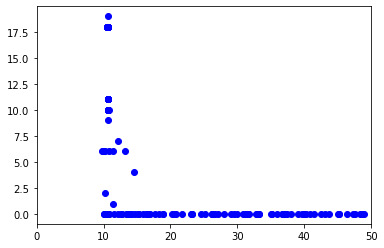

In [5]:
%matplotlib inline

plt.plot(df_for_predict['distance'],df_for_predict['brake'],'bo')

#plt.plot(df_full['distance'],df_full['brake'],'bo')
plt.xlim(0, 50)

plt.show()


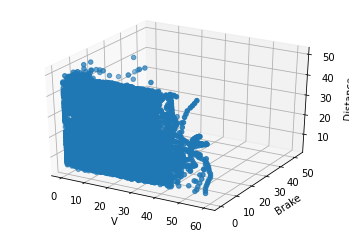

In [6]:
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(near_df['ego_speed'],near_df['brake'],near_df['distance'],marker='o')
ax.set_xlabel('V')
ax.set_ylabel('Brake')
ax.set_zlabel('Distance')

plt.show()

Comme on peut le voir avec le graphique ci dessus,
cette façon de faire avec distance et vitesse à l'instant t seulement n'est pas bonne, car on voit bien qu'il est impossible de prédire quelque chose car les données sont représentés partour dans l'espace. Je vais essayer mtn de rajouter des informations du passé (t-1,-2...) pour avoir plus de paramètres, et j'espère avoir un résultat concret.

## Affichage de la scène à partir d'un dataframe

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [64]:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib qt
#liste_scene = ['scene-0061','scene-0010','scene-0041','scene-0009','scene-0100',
#'scene-0101','scene-0190','scene-0194']

# 61 41 190 194
use_nuscenes = False
scene_name = 'scene-0061'

if use_nuscenes:
    my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
    scene = nusc.get('scene',my_scene_token)
    df = build_dataframe_for_one_scene(scene,False)
else:
    df = df_full[df_full['scene'] == scene_name]
    
df_ego = df[df['inst_token'] == "vehicle_info"]
liste_temps = sorted(set(df['timestamp'].to_list()))

#plt.style.use(['dark_background'])
fig, ax = plt.subplots()
mini = df['ego_pos'].min()
maxi = df['ego_pos'].max()
plt.xlim(mini[0]-100, maxi[0]+100)
plt.ylim(mini[1]-100, maxi[1]+100)

pos = df_ego[['timestamp','ego_pos','ego_speed']]

#Param
ego, = plt.plot(0, 0, 'o')
near_vehicle, = plt.plot(0,0,'o')
text_ego = plt.text(100,100,"")
text_dist = plt.text(100,100,"_ego")
vec_vitesse, = plt.plot(0,0,'-')
pmin, = plt.plot(440,1100,'o')
fct, = plt.plot(0,0,'-')

def animate(frame,arg):
    i = arg[frame]
    ego_pos = pos[pos['timestamp']==i]['ego_pos'].iloc[0]
    ego.set_data(ego_pos[0],ego_pos[1])
       
    list_pos = df[(df['timestamp']==i)&(df['inst_token']!='vehicle_info')]['object_pos'].to_list()
    if len(list_pos)!=0 :
        #print(list_pos)
        a = np.transpose(np.asarray(list_pos))
        near_vehicle.set_data(a[0],a[1])
    
    text_ego.set_text(pos[pos['timestamp']==i].iloc[0,2])
    text_ego.set_x(pos[pos['timestamp']==i].iloc[0,1][0])
    text_ego.set_y(pos[pos['timestamp']==i].iloc[0,1][1])
    
    if frame < len(arg) - 2:
        j = arg[frame+1]
        A = pos[pos['timestamp']==i].iloc[0,1]
        B = pos[pos['timestamp']==j].iloc[0,1]
        AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
        if (AB[0]*AB[0] + AB[1]*AB[1]) == 0:
            ABn = (0,0)
        else:   
            ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)
        vec_vitesse.set_data([A[0], A[0]+ABn[0]*10], [A[1],A[1]+ABn[1]*10])
        #vec_vitesse.set_data([100, 100+log[i][0]*100], [100,100+log[i][1]*100])
        if len(list_pos)!=0 :
            if ABn[0] == 0:
                a = 0
            else:
                a = ABn[1]/ABn[0]
            c = - A[0] * a + A[1]
            dmin = 50
            posmin = []
            for p in list_pos:
                d = np.absolute(p[1] - a * p[0] - c)/ np.sqrt(a*a + 1)
                distance_ego = round(np.linalg.norm(np.array(A) - np.array(p)),3)
                if distance_ego < dmin and d < 3:
                    dmin = distance_ego
                    posmin = p
            if posmin != []:
                pmin.set_data(posmin[0],posmin[1])
                text_dist.set_text(dmin)
                text_dist.set_x(posmin[0])
                text_dist.set_y(posmin[1])        
            #print(dmin,posmin)
            x = np.linspace(mini[0]-50, maxi[0]+50)
            y = a*x + c
            fct.set_data(x,y)   
    #print(i)
    return ego,text_ego,text_dist,near_vehicle,vec_vitesse,pmin,fct,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=len(liste_temps),fargs=([liste_temps]),
                                      interval=250, blit=True, repeat=True)
plt.show()

On faisant une matrice de corrélation, on aperçoit que la distance entre les deux véhicules et un influencer par la vitesse principalement, le frein agit un peu dessus. De plus, la vitesse est trés corrélée avec le frein. L'accélération a un peu d'effet sur la vitesse, voir aucun sur la distance, cela est un peu étonnant.

In [12]:
print(near_df.shape)
near_df.corr()

(15794, 16)


,Unnamed: 0,timestamp,utime,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
Unnamed: 0,1.000000,-0.033492,-0.033492,-0.102644,0.025627,-0.041356,0.007297,0.036816,0.005102,0.034409,-0.043511
timestamp,-0.033492,1.000000,1.000000,-0.054073,-0.045145,0.146509,0.039192,0.038454,0.041304,0.036217,0.148516
utime,-0.033492,1.000000,1.000000,-0.054073,-0.045145,0.146509,0.039192,0.038454,0.041304,0.036217,0.148516
distance,-0.102644,-0.054073,-0.054073,1.000000,0.006357,0.187591,0.047766,-0.120413,0.034953,-0.116605,0.186483
steering,0.025627,-0.045145,-0.045145,0.006357,1.000000,0.028351,0.017093,-0.040247,0.018126,-0.038269,0.029846
ego_speed,-0.041356,0.146509,0.146509,0.187591,0.028351,1.000000,0.214864,-0.468533,0.161799,-0.459499,0.995586
throttle,0.007297,0.039192,0.039192,0.047766,0.017093,0.214864,1.000000,-0.280848,0.878009,-0.284256,0.286158
brake,0.036816,0.038454,0.038454,-0.120413,-0.040247,-0.468533,-0.280848,1.000000,-0.275167,0.937828,-0.484019
future_throttle,0.005102,0.041304,0.041304,0.034953,0.018126,0.161799,0.878009,-0.275167,1.000000,-0.285336,0.228273
future_brake,0.034409,0.036217,0.036217,-0.116605,-0.038269,-0.459499,-0.284256,0.937828,-0.285336,1.000000,-0.476240


# 3/ Apprentissage

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import svm, neighbors
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import operator
import random

In [22]:
features = ["distance","ego_speed"]
#features = [col for col in train_data.columns.to_list() if ('distance' in col or'ego_speed' in col)]
print(features)
y = df_for_predict["futur_speed"]
X = df_for_predict[features]
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

['distance', 'ego_speed']


In [38]:
features = [col for col in df_with_past_data.columns.to_list() if ('distance' in col or'ego_speed' in col)]
y_past = df_with_past_data["futur_speed"]
X_past = df_with_past_data[features]

In [15]:
Xfull = near_df[features]
yfull = near_df['futur_speed']
X_train, X_test, y_train, y_test = train_test_split(Xfull,yfull, test_size = 0.2,random_state=1)

In [16]:
model_reg = linear_model.LinearRegression()
model_reg.fit(X_train,y_train)
print(model_reg.score(X_test,y_test))
model_svr = svm.SVR()
model_svr.fit(X_train,y_train)
print(model_svr.score(X_test,y_test))
model_forest = RandomForestRegressor(n_estimators=100,random_state=0)
model_forest.fit(X_train,y_train)
print(model_forest.score(X_test,y_test))

0.9912672850027179
0.9903451280256642
0.9890119130423751


In [42]:
model_reg2 = linear_model.LinearRegression()
model_reg2.fit(X_past,y_past)
print(features)
model_reg2.score(test[features],test['futur_speed'])

['distance', 'ego_speed', 'distance_1', 'ego_speed_1', 'distance_2', 'ego_speed_2', 'distance_3', 'ego_speed_3', 'distance_4', 'ego_speed_4', 'distance_5', 'ego_speed_5']


0.9945809585625267

Prédire trajectoire en entier...

In [46]:
# Deuxieme version , marche, basé sur calcul de vecteur dans le monde
def compute_distance(pos,ABn,dataframe):
    #dist = np.linalg.norm(np.array(ego['translation']) - np.array(curr_ann['translation']))
    #print(dataframe[['timestamp',"distance"]])
    dataframe = dataframe.drop(columns=['distance'])
    taille = dataframe.shape[0]
    dmin = 99
    mini = 0
    if ABn[0] == 0:
        a = 0
    else:
        a = ABn[1]/ABn[0]
    c = - pos[0] * a + pos[1]    
    for i in range(taille):
        row = dataframe.iloc[i]
        if row["inst_token"] != "vehicle_info":
            distance_ego = round(np.linalg.norm(np.array(pos) - np.array(row['object_pos'][:2])),3)
            #print(distance_ego,end=", ")
            distance_vecteur_vitesse = np.absolute(row['object_pos'][1] - a * row['object_pos'][0] - c)/ np.sqrt(a*a + 1)
            if distance_ego < dmin and distance_vecteur_vitesse < 5:
                dmin = distance_ego
                mini = i
    #print()
    #print("Distance:",dmin," ",dataframe.iloc[mini]['inst_token']," ",dataframe.iloc[mini]['object_pos'])
    return dmin
    
    #ego_pos = [round(e,3) for e in ego['translation']]
    #object_pos = [round(e,3) for e in curr_ann['translation']]
# version simplifie pour pouvoir tester 
def compute_distance_cheat(pos,ABn,dataframe):
    df = dataframe[dataframe['inst_token']=="98300b9c4acb4da9a7aecd0084650265"]
    if df.shape[0] == 0:
        return 99
    
    return round(np.linalg.norm(np.array(pos) - np.array(df.iloc[0]['object_pos'][:2])),3)

# Fonction qui déroule une scene en se basant sur les predictions faites, 
# Point de départ = pos initial puis après calcul à chaque tour de boucle par rapport aux retours des modèles
def predict_scene_v3(scene_name,k_past_data):

    df = df_full[df_full["scene"] == scene_name]
    df_ego = df[df['inst_token'] == "vehicle_info"]
    
    liste_tmsp = sorted(set(df['timestamp'].to_list()))
    nb_tmsp = len(liste_tmsp)
    
    df_summarize = pd.DataFrame(columns=[""])
    #print(df_ego["ego_pos"])
    # Initialisation des paramètres
    speed = df_ego.iloc[0]['ego_speed']
    A = df_ego.iloc[0]['ego_pos'][:2]
    B = df_ego.iloc[1]['ego_pos'][:2]
    print(A,B)
    A = [float(a) for a in A]
    B = [float(b) for b in B]

    log = []
    features = ["distance","ego_speed","throttle","brake"]
    #sample = nusc.get('sample',scene['first_sample_token'])
    #last = scene['last_sample_token']
    #last_s = nusc.get('sample',last)
    #second_last = last_s['prev']
    i = 0
    throttle = [0]
    brake = [0]
    speed = 40

    past_data = [0]*k_past_data*2
    print("Position Predite,    Position Reel,    Distance, vitesse,  ")
    
    # Parcours chaque demi secondes de la scène
    while i != nb_tmsp - 1:
        # Calcul vecteur vitesse et vecteur vitesse normalisé
        AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
        if AB[0]*AB[0] + AB[1]*AB[1] != 0:
            ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)
        else:
            ABn = (0,0) 
            
        # On cherche la distance au véhicule le plus proche dans la direction où on va
        #print(df[df['timestamp']==liste_tmsp[i]][['timestamp',"distance"]])
        distance = compute_distance(A,ABn,df[df['timestamp']==liste_tmsp[i]])
        
        # Paramètres des modèles
        data = [[distance,speed]]
        past_diff = []
        
        #print(past_data)
        for j in range(len(past_data)):
            if j%2 == 0 and past_data[j] != 0:
                past_diff += [round(distance - past_data[j],3)]
            elif j%2 == 1 and past_data[j] != 0:
                past_diff += [round(speed - past_data[j],3)]
            else:
                past_diff += [past_data[j]]

        data2 = [[distance,speed] + past_diff]
        #diff_distance = [distance - d for d in past_distance]
        #diff_speed = [speed - s for s in past_speed]
        #print(data2)
        data3 = [[distance,speed]+past_data]
        
        # Application des modèles
        speed_predict = model_forest.predict(data)
        speed = speed_predict[0]
        speed = round(speed,3)

        if speed < 0:
            speed = 0 
        #print(data2)
        print(liste_tmsp[i],A,df_ego.iloc[i]['ego_pos'][:2],distance,speed,speed_predict, model_reg2.predict(data3), model_reg.predict(data),"\n")
        past_data.append(distance)
        past_data.append(speed)
        past_data.pop(0)
        past_data.pop(0)
        i += 1
        # Calcul nouveau point
        deplacement = [e * speed/3.6*0.5 for e in ABn]        
        log += [ABn]
        A = B
        B = list(map(operator.add, B,deplacement))
        B = df_ego.iloc[i]['ego_pos'][:2]
        B = [round(b,3) for b in B]

    return log
scene_name = 'scene-0006'   
log = predict_scene_v3(scene_name,5)
#37efe5932d7f4084ac8ed3bbb5ed6220  56a9802dbe824219992d60debdea6646   23e14d768eab400099c816a3ac0ff041 98300b9c4acb4da9a7aecd0084650265       
#nusc.render_instance("98300b9c4acb4da9a7aecd0084650265")
print(len(log))
print(log)

[683.173, 1470.356] [688.094, 1469.66]
Position Predite,    Position Reel,    Distance, vitesse,  
1531884156948944 [683.173, 1470.356] [683.173, 1470.356] 7.525 39.988 [39.988] [72.68311302] [39.8616629] 

1531884157448804 [688.094, 1469.66] [688.094, 1469.66] 99 40.051 [40.051] [79.16073235] [39.84642073] 

1531884157949256 [688.094, 1469.66] [692.803, 1468.983] 66.239 39.955 [39.9553] [73.01421256] [39.9103181] 

1531884158448576 [692.803, 1468.983] [697.316, 1468.318] 61.328 40.04 [40.0396] [72.53234256] [39.81492644] 

1531884158948988 [697.316, 1468.318] [701.564, 1467.677] 56.674 40.046 [40.0458] [62.08543171] [39.89971218] 

1531884159448859 [701.564, 1467.677] [705.693, 1467.038] 52.286 39.96 [39.9598] [39.94464135] [39.90584333] 

1531884159949288 [705.693, 1467.038] [709.602, 1466.428] 48.017 40.04 [40.0396] [39.88751716] [39.8203836] 

1531884160399393 [709.602, 1466.428] [712.91, 1465.934] 43.969 40.037 [40.0373] [40.02084379] [39.90016998] 

1531884160898719 [712.91, 1465

In [39]:
2 + 2

4

## Amélioration modèle 

### Modèle basique: distance + ego_speed

In [60]:
features = ["distance","ego_speed"]
df = df_for_predict.copy()
y = df["futur_speed"]
X = df[features]
Xnear = near_df[features]
ynear = near_df['futur_speed']
_, X_test, _, y_test = train_test_split(Xnear,ynear, test_size = 0.2, random_state = 1)
model_b2 = RandomForestRegressor(n_estimators=100,random_state=0)
model_b2.fit(X,y)
best_score = 0
print("Score initial: ",best_score)

scenes  = list(sorted(set(near_df['scene'].to_list())))
scenes_in_df = list(sorted(set(df['scene'].to_list())))
scenes = scenes[:200]
taille = len(scenes)
i = 0
for s in scenes:
    if i % (taille/10) == 0:
        print(i,score)
    if s not in scenes_in_df:
        df_curr = near_df[near_df['scene']==s]
        X = df[features]
        X = X.append(df_curr[features],ignore_index=True)
        y = df["futur_speed"]
        y = y.append(df_curr["futur_speed"],ignore_index=True)
        model_b2.fit(X,y)
        score = model_b2.score(X_test,y_test)
        if score > best_score:
            df = df.append(df_curr,ignore_index=True)
            best_score = score
    i += 1
print("Score finale: ",best_score)


Score initial:  0
0 0.9860969533645148


### Modele avancé: distance + speed + données antérieurs

In [133]:
features = ["distance","ego_speed"]
# if ('distance' in col or'ego_speed' in col)
features = [col for col in near_data_bis.columns.to_list() if ('diff' in col in col)]
print(features)

['d_diff_1', 's_diff_1', 'd_diff_2', 's_diff_2', 'd_diff_3', 's_diff_3', 'd_diff_4', 's_diff_4', 'd_diff_5', 's_diff_5']


In [36]:
features = ['distance','ego_speed'] + [col for col in near_data_bis.columns.to_list() if ('diff' in col)][:4]
df = df_with_past_data.copy()
X = df[features]
y = df["futur_speed"]

train = near_data_bis.iloc[:int(near_data_bis.shape[0]*0.8),:]
test = near_data_bis.iloc[int(near_data_bis.shape[0]*0.8):,:]
#svm.SVR()
model_reg2 = svm.SVR()
#model_b5 = svm.SVR()

model_reg2.fit(train[features],train['futur_speed'])
best_score = model_reg2.score(test[features],test['futur_speed'])
print("Score initial: ",best_score)
print(features)

Score initial:  0.9817899263988592
['distance', 'ego_speed', 'd_diff_1', 's_diff_1', 'd_diff_2', 's_diff_2']


In [103]:
features = [col for col in near_data_bis.columns.to_list() if ('diff' in col)]
df = df_with_past_data.copy()
X = df[features]
y = df["futur_speed"]

train = near_data_bis.iloc[:int(near_data_bis.shape[0]*0.8),:]
test = near_data_bis.iloc[int(near_data_bis.shape[0]*0.8):,:]
#svm.SVR()
model_b5 = RandomForestRegressor(n_estimators=100,random_state=0)
#model_b5 = svm.SVR()

model_b5.fit(X,y)
best_score = 0
print("Score initial: ",best_score)

scenes  = list(sorted(set(train['scene'].to_list())))
scenes_in_df = list(sorted(set(df['scene'].to_list())))
scenes = scenes[:200]
taille = len(scenes)
i = 0
for s in scenes:
    #print(s)
    if i % (taille/10) == 0:
        #print(s,':',score,len(X))
        pass

    
    if s not in scenes_in_df:
        df_curr = train[train['scene']==s]
        X = df[features]
        X = X.append(df_curr[features],ignore_index=True)
        y = df["futur_speed"]
        y = y.append(df_curr["futur_speed"],ignore_index=True)
        model_b5.fit(X,y)
        score = model_b5.score(test[features],test['futur_speed'])

        if score > best_score:
            df = df.append(df_curr,ignore_index=True)
            best_score = score
            print(s,':',score,len(X))
    i += 1
print("Score final: ",score)

Score initial:  0
scene-0001 : 0.24444979970190328 219
scene-0002 : 0.24150267128023195 229
scene-0004 : 0.24238101444151505 246
scene-0005 : 0.25490290395938353 277
scene-0006 : 0.23163449355437415 297
scene-0007 : 0.25448109006239805 306
scene-0008 : 0.253151697428598 317
scene-0011 : 0.2494930887568908 346
scene-0013 : 0.24788272456892668 377
scene-0014 : 0.24867108454034603 400
scene-0015 : 0.26339950018251834 432
scene-0016 : 0.2638068406392885 446
scene-0017 : 0.25760647783845314 457
scene-0018 : 0.24841829446217656 481
scene-0020 : 0.24563856326474998 491
scene-0021 : 0.1967075529479807 511
scene-0022 : 0.19912822718681233 516
scene-0023 : 0.198516650666255 518
scene-0024 : 0.19681193598516122 523
scene-0026 : 0.19634519746547308 540
scene-0027 : 0.19227045123999598 545
scene-0028 : 0.19542510566258342 554
scene-0030 : 0.20167941438324044 567
scene-0031 : 0.20095753960632223 576
scene-0033 : 0.21051030707132934 580
scene-0034 : 0.20500467689960278 587
scene-0035 : 0.198512353483

# Brouillon / animation / recherche de données

In [33]:
near_data_bis.iloc[:,7:]

,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,distance_1,...,d_diff_3,s_diff_3,distance_4,ego_speed_4,d_diff_4,s_diff_4,distance_5,ego_speed_5,d_diff_5,s_diff_5
0,"[1003.027, 623.908, 0.0]","[967.127, 652.084, 1.903]",45.676,-0.6,20.42,140,0,42,0,47.881,...,30.790,3.18,17.021,16.10,28.655,4.32,19.073,15.19,26.603,5.23
1,"[1000.89, 625.732, 0.0]","[967.187, 652.158, 1.843]",42.868,-1.0,21.13,42,0,0,0,45.676,...,20.520,2.71,14.886,17.24,27.982,3.89,17.021,16.10,25.847,5.03
2,"[998.647, 627.648, 0.0]","[967.165, 652.13, 1.783]",39.921,-1.0,21.00,0,0,0,0,42.868,...,-7.960,1.39,22.348,18.42,17.573,2.58,14.886,17.24,25.035,3.76
3,"[996.399, 629.583, 0.0]","[967.215, 652.194, 1.723]",36.959,-0.7,20.42,0,0,0,0,39.921,...,-8.717,0.00,47.881,19.61,-10.922,0.81,22.348,18.42,14.611,2.00
4,"[994.178, 631.494, 0.0]","[967.204, 652.18, 1.713]",34.036,0.5,19.70,0,0,0,0,36.959,...,-8.832,-1.43,45.676,20.42,-11.640,-0.72,47.881,19.61,-13.845,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11029,"[1545.18, 1388.732, 0.0]","[1542.435, 1367.824, 0.085]",21.088,-49.1,33.40,224,0,224,0,20.479,...,3.284,8.67,16.772,22.54,4.316,10.86,15.402,20.70,5.686,12.70
11030,"[1544.734, 1383.837, 0.0]","[1541.531, 1362.286, 0.338]",21.790,-48.6,35.53,224,0,143,0,21.088,...,2.456,7.93,17.804,24.73,3.986,10.80,16.772,22.54,5.018,12.99
11031,"[1543.773, 1378.855, 0.0]","[1540.627, 1356.753, 0.34]",22.328,-27.4,36.64,143,0,115,0,21.790,...,1.849,6.11,19.334,27.60,2.994,9.04,17.804,24.73,4.524,11.91
11032,"[1542.365, 1373.843, 0.0]","[1539.723, 1351.221, 0.368]",22.778,-3.4,37.29,115,0,122,0,22.328,...,1.690,3.89,20.479,30.53,2.299,6.76,19.334,27.60,3.444,9.69


In [17]:
df_ego = df[df['inst_token'] == "vehicle_info"]
#df_ego

list_vec = [(df_ego.iloc[i+1]['ego_pos'][0] - df_ego.iloc[i]['ego_pos'][0],
            df_ego.iloc[i+1]['ego_pos'][1] - df_ego.iloc[i]['ego_pos'][1]) 
            for i in range(df_ego.shape[0]-1) ]
list_vitesse = [df_ego.iloc[i]['ego_speed'] for i in range(df_ego.shape[0]-1)]
list_vec_norm = [ (v[0]/np.sqrt((v[0]*v[0] + v[1]*v[1])),v[1]/np.sqrt((v[0]*v[0] + v[1]*v[1])))
            for v in list_vec ]
for i in range(df_ego.shape[0]-1):
    # tuple(map(operator.add, df_ego.iloc[i]['ego_pos'],
    r = [e * list_vitesse[i]/3.6*0.5 for e in list_vec_norm[i]]
    #print(list_vec_norm[i])
    new_pos =   list(map(operator.add, df_ego.iloc[i]['ego_pos'],r))
    new_pos = [round(e,3) for e in new_pos]    
    #print(new_pos,df_ego.iloc[i+1]['ego_pos'])

In [19]:
# version avec nuscenes
def predict_scene_v3_nu(scene_name,k_past_data):
    my_scene_token = nusc.field2token('scene', 'name', scene_name)[0]
    scene = nusc.get('scene',my_scene_token)
    #nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')
    df = build_dataframe_for_one_scene(scene,False)
    df_ego = df[df['inst_token'] == "vehicle_info"]
    
    df_summarize = pd.DataFrame(columns=[""])
    
    # Initialisation des paramètres
    speed = df_ego.iloc[0]['ego_speed']
    A = df_ego.iloc[0]['ego_pos'][:2]
    B = df_ego.iloc[1]['ego_pos'][:2]
    AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
    ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)
    #print(A,B,AB,ABn)
    log = []
    features = ["distance","ego_speed","throttle","brake"]
    sample = nusc.get('sample',scene['first_sample_token'])
    last = scene['last_sample_token']
    last_s = nusc.get('sample',last)
    second_last = last_s['prev']
    i = 0
    throttle = [0]
    brake = [0]
    speed = 40

    
    past_data = [0]*k_past_data*2
    print("Position Predite,    Position Reel,    Distance, vitesse,  ")
    # Boucle
    while sample['token'] != second_last:
        distance = compute_distance(A,ABn,df[df['timestamp']==sample['timestamp']])
        data = [[distance,speed]]
        data2 = [[distance,speed]+past_data]
        #diff_distance = [distance - d for d in past_distance]
        #diff_speed = [speed - s for s in past_speed]
        #print(data2)
        
        speed_predict = model_forest.predict(data)
        speed = speed_predict[0]
        speed = round(speed,3)

        if speed < 0:
            speed = 0 
        print(B,df_ego.iloc[i]['ego_pos'][:2],distance,speed,speed_predict, model_reg.predict(data), model_b5.predict(data2),"\n")

        # Calcul nouveau point
        A = B
        deplacement = [e * speed/3.6*0.5 for e in ABn]
        B = list(map(operator.add, B,deplacement))
        i += 1
        B = df_ego.iloc[i]['ego_pos'][:2]
        #B = [round(b,3) for b in B]
        sample = nusc.get('sample',sample['next'])
        AB =   [round(B[0] - A[0],3),round(B[1] - A[1],3)]
        if AB[0]*AB[0] + AB[1]*AB[1] != 0:
            ABn = round(AB[0]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3),round(AB[1]/np.sqrt((AB[0]*AB[0] + AB[1]*AB[1])),3)
        else:
            ABn = (0,0)
        log += [ABn]
        past_data.append(distance)
        past_data.append(speed)
        past_data.pop(0)
        past_data.pop(0)
        #print(past_data)

    return log
scene_name = 'scene-0006'    
log = predict_scene_v3_nu(scene_name,5)
print(len(log))
print(log)

NameError: name 'nusc' is not defined

In [75]:
#near_df = pd.read_csv('./data/near_dataframe_full.csv')
near_df.shape

(15794, 16)

In [54]:
# Pas opti (copy, à améliorer)
# Ajout de colonnes dans le dataframe pour les informations antérieurs (distance + vitesse)
def add_past_data_to_dataframe(dataframe,k_past_data):
    clmns = dataframe.columns.to_list()
    for j in range(1,k_past_data+1):
        clmns += ['distance_'+str(j)] + ['ego_speed_'+str(j)]
    new_df = pd.DataFrame(columns=clmns)
    set_scene = sorted(set(dataframe['scene'].to_list()))
    for s in set_scene:
        df_curr =  dataframe[dataframe['scene']==s]
        for i in range(k_past_data,df_curr.shape[0]):
            row = df_curr.iloc[i].copy()
            for j in range(1,k_past_data+1):
                row['distance_'+str(j)] = df_curr.iloc[i-j]['distance']
                row['ego_speed_'+str(j)] = df_curr.iloc[i-j]['ego_speed']
            new_df = new_df.append(row)
    #display(new_df)
    print(new_df.shape)
    return new_df        

#near_data = add_past_data_to_dataframe(near_df,5)
#features = [col for col in near_data.columns.to_list() if ('distance' in col or'ego_speed' in col)]
#print(near_data.columns,features)

(11034, 25)
Index(['Unnamed: 0', 'scene', 'timestamp', 'utime', 'inst_token', 'ann_token',
       'ego_pos', 'object_pos', 'distance', 'steering', 'ego_speed',
       'throttle', 'brake', 'future_throttle', 'future_brake', 'distance_1',
       'ego_speed_1', 'distance_2', 'ego_speed_2', 'distance_3', 'ego_speed_3',
       'distance_4', 'ego_speed_4', 'distance_5', 'ego_speed_5'],
      dtype='object') ['distance', 'ego_speed', 'distance_1', 'ego_speed_1', 'distance_2', 'ego_speed_2', 'distance_3', 'ego_speed_3', 'distance_4', 'ego_speed_4', 'distance_5', 'ego_speed_5']


In [30]:
# Pas opti (copy, à améliorer)
# Ajout de colonnes dans le dataframe pour les informations antérieurs (distance + vitesse) avec diff
def add_past_data_to_dataframe_v2(dataframe,k_past_data):
    clmns = dataframe.columns.to_list()
    for j in range(1,k_past_data+1):
        clmns += ['distance_'+str(j)] + ['ego_speed_'+str(j)]
    new_df = pd.DataFrame(columns=clmns)
    set_scene = sorted(set(dataframe['scene'].to_list()))
    for s in set_scene:
        df_curr =  dataframe[dataframe['scene']==s]
        for i in range(k_past_data,df_curr.shape[0]):
            row = df_curr.iloc[i].copy()
            for j in range(1,k_past_data+1):
                row['distance_'+str(j)]  = df_curr.iloc[i]['distance']  - df_curr.iloc[i-j]['distance'] 
                row['ego_speed_'+str(j)] = df_curr.iloc[i]['ego_speed'] - df_curr.iloc[i-j]['ego_speed'] 
            new_df = new_df.append(row)
    #display(new_df)
    print(new_df.shape)
    return new_df        

#near_data_bis = add_past_data_to_dataframe_v2(near_df,5)
features = [col for col in near_data_bis.columns.to_list() if ('distance' in col or'ego_speed' in col)]
print(near_data_bis.columns,features)

(11034, 25)
Index(['Unnamed: 0', 'scene', 'timestamp', 'utime', 'inst_token', 'ann_token',
       'ego_pos', 'object_pos', 'distance', 'steering', 'ego_speed',
       'throttle', 'brake', 'future_throttle', 'future_brake', 'distance_1',
       'ego_speed_1', 'distance_2', 'ego_speed_2', 'distance_3', 'ego_speed_3',
       'distance_4', 'ego_speed_4', 'distance_5', 'ego_speed_5'],
      dtype='object') ['distance', 'ego_speed', 'distance_1', 'ego_speed_1', 'distance_2', 'ego_speed_2', 'distance_3', 'ego_speed_3', 'distance_4', 'ego_speed_4', 'distance_5', 'ego_speed_5']


In [34]:
# Pas opti (copy, à améliorer)
# Ajout de colonnes dans le dataframe pour les informations antérieurs (distance + vitesse) normal + diff
def add_past_data_to_dataframe_v3(dataframe,k_past_data):
    clmns = dataframe.columns.to_list()
    for j in range(1,k_past_data+1):
        clmns += ['distance_'+str(j)] + ['ego_speed_'+str(j)] + ['d_diff_'+str(j)] + ['s_diff_'+str(j)]
    new_df = pd.DataFrame(columns=clmns)
    set_scene = sorted(set(dataframe['scene'].to_list()))
    for s in set_scene:
        df_curr =  dataframe[dataframe['scene']==s]
        for i in range(k_past_data,df_curr.shape[0]):
            row = df_curr.iloc[i].copy()
            for j in range(1,k_past_data+1):
                row['d_diff_'+str(j)]  = df_curr.iloc[i]['distance']  - df_curr.iloc[i-j]['distance'] 
                row['s_diff_'+str(j)] = df_curr.iloc[i]['ego_speed'] - df_curr.iloc[i-j]['ego_speed'] 
                row['distance_'+str(j)] = df_curr.iloc[i-j]['distance']
                row['ego_speed_'+str(j)] = df_curr.iloc[i-j]['ego_speed']
            new_df = new_df.append(row)
    #display(new_df)
    print(new_df.shape)
    return new_df        

near_data_bis = add_past_data_to_dataframe_v3(near_df,5)
features = [col for col in near_data_bis.columns.to_list() if ('distance' in col or'ego_speed' in col)]
print(near_data_bis.columns,features)

(12157, 36)
Index(['Unnamed: 0', 'scene', 'timestamp', 'utime', 'inst_token', 'ann_token',
       'ego_pos', 'object_pos', 'distance', 'steering', 'ego_speed',
       'throttle', 'brake', 'future_throttle', 'future_brake', 'futur_speed',
       'distance_1', 'ego_speed_1', 'd_diff_1', 's_diff_1', 'distance_2',
       'ego_speed_2', 'd_diff_2', 's_diff_2', 'distance_3', 'ego_speed_3',
       'd_diff_3', 's_diff_3', 'distance_4', 'ego_speed_4', 'd_diff_4',
       's_diff_4', 'distance_5', 'ego_speed_5', 'd_diff_5', 's_diff_5'],
      dtype='object') ['distance', 'ego_speed', 'distance_1', 'ego_speed_1', 'distance_2', 'ego_speed_2', 'distance_3', 'ego_speed_3', 'distance_4', 'ego_speed_4', 'distance_5', 'ego_speed_5']


In [35]:
display(near_data_bis[near_data_bis['brake'] > 0].iloc[:,8:])
display(near_data_bis[near_data_bis['brake'] == 0].iloc[:,8:])
near_data_bis.to_csv("./data/near_data_past_diff_data1007.csv")

,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed,distance_1,ego_speed_1,...,d_diff_3,s_diff_3,distance_4,ego_speed_4,d_diff_4,s_diff_4,distance_5,ego_speed_5,d_diff_5,s_diff_5
108,29.803,-14.9,21.99,0,1,0,0,20.24,33.185,23.32,...,-10.840,-3.21,44.083,26.24,-14.280,-4.25,48.133,27.53,-18.330,-5.54
310,30.211,-2.6,22.33,0,1,0,0,21.36,30.972,22.67,...,-1.786,-0.72,32.214,23.32,-2.003,-0.99,32.495,23.58,-2.284,-1.25
364,21.941,64.3,9.61,0,3,0,6,8.10,23.746,11.15,...,-7.316,-4.86,33.106,16.30,-11.165,-6.69,32.392,18.25,-10.451,-8.64
365,20.629,89.2,8.10,0,6,0,8,6.62,21.941,9.61,...,-5.507,-4.65,29.257,14.47,-8.628,-6.37,33.106,16.30,-12.477,-8.20
366,19.792,99.4,6.62,0,8,0,8,5.18,20.629,8.10,...,-3.954,-4.53,26.136,12.75,-6.344,-6.13,29.257,14.47,-9.465,-7.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15763,6.982,8.6,6.58,0,16,0,18,3.79,7.502,8.89,...,-2.235,-5.57,9.694,13.50,-2.712,-6.92,10.290,13.64,-3.308,-7.06
15764,6.429,8.6,3.79,0,18,0,18,1.10,6.982,6.58,...,-1.817,-6.72,9.217,12.15,-2.788,-8.36,9.694,13.50,-3.265,-9.71
15765,6.280,8.6,1.10,0,18,0,15,0.00,6.429,3.79,...,-1.222,-7.79,8.246,10.51,-1.966,-9.41,9.217,12.15,-2.937,-11.05
15766,6.307,8.8,0.00,0,15,0,14,0.00,6.280,1.10,...,-0.675,-6.58,7.502,8.89,-1.195,-8.89,8.246,10.51,-1.939,-10.51


,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed,distance_1,ego_speed_1,...,d_diff_3,s_diff_3,distance_4,ego_speed_4,d_diff_4,s_diff_4,distance_5,ego_speed_5,d_diff_5,s_diff_5
5,45.676,-0.6,20.42,140,0,42,0,21.13,47.881,19.61,...,30.790,3.18,17.021,16.10,28.655,4.32,19.073,15.19,26.603,5.23
6,42.868,-1.0,21.13,42,0,0,0,21.00,45.676,20.42,...,20.520,2.71,14.886,17.24,27.982,3.89,17.021,16.10,25.847,5.03
7,39.921,-1.0,21.00,0,0,0,0,20.42,42.868,21.13,...,-7.960,1.39,22.348,18.42,17.573,2.58,14.886,17.24,25.035,3.76
8,36.959,-0.7,20.42,0,0,0,0,19.70,39.921,21.00,...,-8.717,0.00,47.881,19.61,-10.922,0.81,22.348,18.42,14.611,2.00
9,34.036,0.5,19.70,0,0,0,0,18.87,36.959,20.42,...,-8.832,-1.43,45.676,20.42,-11.640,-0.72,47.881,19.61,-13.845,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15789,21.088,-49.1,33.40,224,0,224,0,35.53,20.479,30.53,...,3.284,8.67,16.772,22.54,4.316,10.86,15.402,20.70,5.686,12.70
15790,21.790,-48.6,35.53,224,0,143,0,36.64,21.088,33.40,...,2.456,7.93,17.804,24.73,3.986,10.80,16.772,22.54,5.018,12.99
15791,22.328,-27.4,36.64,143,0,115,0,37.29,21.790,35.53,...,1.849,6.11,19.334,27.60,2.994,9.04,17.804,24.73,4.524,11.91
15792,22.778,-3.4,37.29,115,0,122,0,37.93,22.328,36.64,...,1.690,3.89,20.479,30.53,2.299,6.76,19.334,27.60,3.444,9.69


In [21]:
df = df_for_predict.copy()
df_with_past_data = add_past_data_to_dataframe_v3(df,5)

(195, 36)


In [124]:
display(near_df)
display(near_data)

,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,ego_speed,throttle,brake,future_throttle,future_brake,futur_speed
6,scene-0001,1531883531450214,1531883531890914,39b6c31c9925492a8a9f1b0ef3b877b6,8feca495e3614382b12a6637c82c4670,"[1010.029, 614.858, 0.0]","[1002.499, 632.296, 1.736]",19.073,206.3,15.19,158,0,182,0,16.10
11,scene-0001,1531883531950107,1531883532391342,39b6c31c9925492a8a9f1b0ef3b877b6,e70a018c1c5541069187b4fdad085b43,"[1009.423, 616.759, 0.0]","[1002.407, 632.18, 1.636]",17.021,192.3,16.10,182,0,202,0,17.24
13,scene-0001,1531883532449967,1531883532891863,39b6c31c9925492a8a9f1b0ef3b877b6,818fbb98a43b4d7e8ff39e2048b2ff0b,"[1008.359, 618.663, 0.0]","[1002.336, 632.183, 1.586]",14.886,120.1,17.24,202,0,192,0,18.42
21,scene-0001,1531883533049931,1531883533391538,a1f53dd65da64eb2b0cec51d57b8c047,61c51ee897dd419f84ff3104735e6fd6,"[1006.589, 620.73, 0.0]","[994.03, 639.159, 1.431]",22.348,41.9,18.42,192,0,175,0,19.61
25,scene-0001,1531883533550364,1531883533891107,6efa17d08f464d72bbf5613e7149a5b0,b312f1d6f63c4fd19aaceb25af74b160,"[1004.702, 622.474, 0.0]","[967.067, 652.009, 1.963]",47.881,3.3,19.61,175,0,140,0,20.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,scene-1110,1542801724948810,1542801725110382,0f5deef3cdab4d5f8774e64df363a6f3,061fb990989c49eea70c1b9981e97302,"[1545.18, 1388.732, 0.0]","[1542.435, 1367.824, 0.085]",21.088,-49.1,33.40,224,0,224,0,35.53
154,scene-1110,1542801725449194,1542801725610261,0f5deef3cdab4d5f8774e64df363a6f3,9fc14a0111b24704a65a15913e02f197,"[1544.734, 1383.837, 0.0]","[1541.531, 1362.286, 0.338]",21.790,-48.6,35.53,224,0,143,0,36.64
160,scene-1110,1542801725949047,1542801726110231,0f5deef3cdab4d5f8774e64df363a6f3,2e1955a94dd649238276f8141726e21c,"[1543.773, 1378.855, 0.0]","[1540.627, 1356.753, 0.34]",22.328,-27.4,36.64,143,0,115,0,37.29
171,scene-1110,1542801726448920,1542801726609829,0f5deef3cdab4d5f8774e64df363a6f3,c16795828e364c7d9de7c71b449291f8,"[1542.365, 1373.843, 0.0]","[1539.723, 1351.221, 0.368]",22.778,-3.4,37.29,115,0,122,0,37.93


NameError: name 'near_data' is not defined

In [48]:
features = ["distance","ego_speed"]
features = [col for col in near_data_bis.columns.to_list() if ('distance' in col or'ego_speed' in col)]
print(features)

['distance', 'ego_speed', 'distance_1', 'ego_speed_1', 'distance_diff_1', 'ego_speed_diff_1', 'distance_2', 'ego_speed_2', 'distance_diff_2', 'ego_speed_diff_2', 'distance_3', 'ego_speed_3', 'distance_diff_3', 'ego_speed_diff_3', 'distance_4', 'ego_speed_4', 'distance_diff_4', 'ego_speed_diff_4', 'distance_5', 'ego_speed_5', 'distance_diff_5', 'ego_speed_diff_5']


In [56]:
features = [col for col in train_data.columns.to_list() if ('distance' in col or'ego_speed' in col)]
print(features)
y_brake = df["brake"]
df = df_with_past_data.copy()
X = df[features]
y_brake = df["brake"]
Xnear = train_data[features]
ynear = train_data['brake']
_, Xb_test, _, yb_test = train_test_split(Xnear,ynear, test_size = 0.2, random_state = 1)
model_b3 = RandomForestRegressor(n_estimators=100,random_state=0)
model_b3.fit(X,y_brake)
best_score = 0
print("Score initial: ",best_score)

scenes  = list(sorted(set(near_df['scene'].to_list())))
scenes_in_df = list(sorted(set(df['scene'].to_list())))
for s in scenes[:2]:
    #print(s)
    if s not in scenes_in_df:
        df_curr = train_data[train_data['scene']==s]
        X = df[features]
        X = X.append(df_curr[features],ignore_index=True)
        y_brake = df["brake"]
        y_brake = y_brake.append(df_curr["brake"],ignore_index=True)
        model_b3.fit(X,y_brake)
        score = model_b3.score(Xb_test,yb_test)
        if score > best_score:
            df = df.append(df_curr,ignore_index=True)
            best_score = score
            print(score,len(X))
    else:
        print(s)

NameError: name 'train_data' is not defined

In [47]:
features = [col for col in near_data_bis.columns.to_list() if ('distance' in col or'ego_speed' in col)]
features = features
features


NameError: name 'near_data_bis' is not defined

In [57]:
from sklearn.neighbors import KNeighborsRegressor
features = [col for col in near_data.columns.to_list() if ('distance' in col or'ego_speed' in col)]

#_, Xb_test, _, yb_test = train_test_split(Xnear,ynear, test_size = 0.2, random_state = 1)

y_brake = df["brake"]
df = df_with_past_data.copy()
X = df[features]
y_brake = df["brake"]

train = near_data.iloc[:int(near_data_bis.shape[0]*0.8),:]
test = near_data.iloc[int(near_data_bis.shape[0]*0.8):,:]
#svm.SVR()
model_b3 = RandomForestRegressor(n_estimators=100,random_state=0)
#model_b3 = KNeighborsRegressor(n_neighbors=5)

model_b3.fit(X,y_brake)
best_score = 0
print("Score initial: ",best_score)

scenes  = list(sorted(set(train['scene'].to_list())))
scenes_in_df = list(sorted(set(df['scene'].to_list())))
for s in scenes:
    #print(s)
    if s not in scenes_in_df:
        df_curr = train[train['scene']==s]
        X = df[features]
        X = X.append(df_curr[features],ignore_index=True)
        y_brake = df["brake"]
        y_brake = y_brake.append(df_curr["brake"],ignore_index=True)
        model_b3.fit(X,y_brake)
        score = model_b3.score(test[features],test['brake'])
        #score = model_b3.score(Xb_test,yb_test)

        if score > best_score:
            df = df.append(df_curr,ignore_index=True)
            best_score = score
            print(s,':',score,len(X))
    else:
        print(s)

Score initial:  0
scene-0001 : 0.25474895110366824 219
scene-0004 : 0.2565678504893939 236
scene-0009
scene-0010
scene-0011 : 0.25972000633867975 265
scene-0013 : 0.2621343411023995 296
scene-0016 : 0.2644664402671397 310
scene-0017 : 0.2760976167947494 321
scene-0020 : 0.2821744504926307 331
scene-0026 : 0.2833426039946787 348
scene-0028 : 0.2834376704479299 357
scene-0041
scene-0046 : 0.3035271435559982 370
scene-0049 : 0.30442063198059843 374
scene-0054 : 0.30605762176638707 400
scene-0061
scene-0063 : 0.3206777300762841 403
scene-0066 : 0.34249139171415577 405
scene-0069 : 0.3425591430062018 406
scene-0074 : 0.36041801011942975 420
scene-0096 : 0.3622019965628057 440
scene-0101
scene-0102 : 0.3623139214503126 449
scene-0129 : 0.3625757061812266 451
scene-0131 : 0.36588322872624046 452
scene-0178 : 0.36598828062395194 460
scene-0180 : 0.3665376083406916 476
scene-0190 : 0.375752975246774 497
scene-0191 : 0.3806999833954918 509
scene-0212 : 0.3835167612092808 510
scene-0219 : 0.38456

In [58]:
near_data

,Unnamed: 0,scene,timestamp,utime,inst_token,ann_token,ego_pos,object_pos,distance,steering,...,distance_1,ego_speed_1,distance_2,ego_speed_2,distance_3,ego_speed_3,distance_4,ego_speed_4,distance_5,ego_speed_5
5,28,scene-0001,1531883533950168,1531883534391429,6efa17d08f464d72bbf5613e7149a5b0,ee163ec0d63742419af0c2b899b92366,"[1003.027, 623.908, 0.0]","[967.127, 652.084, 1.903]",45.676,-0.6,...,47.881,19.61,22.348,18.42,14.886,17.24,17.021,16.10,19.073,15.19
6,35,scene-0001,1531883534449471,1531883534891038,6efa17d08f464d72bbf5613e7149a5b0,32baf25a1e7f451cab6d867fc33951ad,"[1000.89, 625.732, 0.0]","[967.187, 652.158, 1.843]",42.868,-1.0,...,45.676,20.42,47.881,19.61,22.348,18.42,14.886,17.24,17.021,16.10
7,43,scene-0001,1531883534949354,1531883535391080,6efa17d08f464d72bbf5613e7149a5b0,3f4c0a6b9a944ef4a18d4d044429f07d,"[998.647, 627.648, 0.0]","[967.165, 652.13, 1.783]",39.921,-1.0,...,42.868,21.13,45.676,20.42,47.881,19.61,22.348,18.42,14.886,17.24
8,47,scene-0001,1531883535448683,1531883535890913,6efa17d08f464d72bbf5613e7149a5b0,d283c0e538b04c99b7d1a7fa77ac0760,"[996.399, 629.583, 0.0]","[967.215, 652.194, 1.723]",36.959,-0.7,...,39.921,21.00,42.868,21.13,45.676,20.42,47.881,19.61,22.348,18.42
9,51,scene-0001,1531883535948561,1531883536391479,6efa17d08f464d72bbf5613e7149a5b0,9bf45a69d41f49648701bccb016b95e9,"[994.178, 631.494, 0.0]","[967.204, 652.18, 1.713]",34.036,0.5,...,36.959,20.42,39.921,21.00,42.868,21.13,45.676,20.42,47.881,19.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14490,149,scene-1110,1542801724948810,1542801725110382,0f5deef3cdab4d5f8774e64df363a6f3,061fb990989c49eea70c1b9981e97302,"[1545.18, 1388.732, 0.0]","[1542.435, 1367.824, 0.085]",21.088,-49.1,...,20.479,30.53,19.334,27.60,17.804,24.73,16.772,22.54,15.402,20.70
14491,154,scene-1110,1542801725449194,1542801725610261,0f5deef3cdab4d5f8774e64df363a6f3,9fc14a0111b24704a65a15913e02f197,"[1544.734, 1383.837, 0.0]","[1541.531, 1362.286, 0.338]",21.790,-48.6,...,21.088,33.40,20.479,30.53,19.334,27.60,17.804,24.73,16.772,22.54
14492,160,scene-1110,1542801725949047,1542801726110231,0f5deef3cdab4d5f8774e64df363a6f3,2e1955a94dd649238276f8141726e21c,"[1543.773, 1378.855, 0.0]","[1540.627, 1356.753, 0.34]",22.328,-27.4,...,21.790,35.53,21.088,33.40,20.479,30.53,19.334,27.60,17.804,24.73
14493,171,scene-1110,1542801726448920,1542801726609829,0f5deef3cdab4d5f8774e64df363a6f3,c16795828e364c7d9de7c71b449291f8,"[1542.365, 1373.843, 0.0]","[1539.723, 1351.221, 0.368]",22.778,-3.4,...,22.328,36.64,21.790,35.53,21.088,33.40,20.479,30.53,19.334,27.60


In [103]:
model_b4 = RandomForestRegressor(n_estimators=100,random_state=0)
model_b4.fit(train[features],train['brake'])
score = model_b4.score(test[features],test['brake'])
print(score)

0.4387774746719091


V1

In [158]:
#features = [col for col in train_data.columns.to_list() if ('distance' in col or'ego_speed' in col)]
y_brake = df["brake"]
df = df_with_past_data.copy()
X = df[features]
y_brake = df["brake"]
Xnear = train_data[features]
ynear = train_data['brake']
_, Xb_test, _, yb_test = train_test_split(Xnear,ynear, test_size = 0.2, random_state = 1)
model_b2 = RandomForestRegressor(n_estimators=100,random_state=0)
model_b2.fit(X,y_brake)
best_score = model_b2.score(Xb_test,yb_test)
print("Score initial: ",best_score)

scenes  = list(sorted(set(near_df['scene'].to_list())))
scenes_in_df = list(sorted(set(df['scene'].to_list())))
for s in scenes[:10]:
    #print(s)
    if s not in scenes_in_df:
        df_curr = train_data[train_data['scene']==s]
        X = df[features]
        X = X.append(df_curr[features],ignore_index=True)
        y_brake = df["brake"]
        y_brake = y_brake.append(df_curr["brake"],ignore_index=True)
        model_b2.fit(X,y_brake)
        score = model_b2.score(Xb_test,yb_test)
        if score > best_score:
            df = df.append(df_curr,ignore_index=True)
            best_score = score
            print(score,len(X))
    else:
        print(s)

Score initial:  0.2585236382428864
0.26311898896267194 285
0.2633685986040254 295
0.2692559755179854 326
scene-0009
scene-0010
